In [1]:
from __future__ import print_function
__author__= 'Pablo Mandiola'

import os
from subprocess import Popen, PIPE
import requests
from zipfile import ZipFile

import geopandas as gpd
import pandas as pd
import numpy as np

#For plotting
import matplotlib.pylab as plt
import seaborn as sns
sns.set(context='notebook', style='whitegrid', palette='deep', font='DejaVu Sans', font_scale=1.2, rc=None)
%matplotlib inline

/usr/local/Anaconda3-5.0.0-Linux-x86_64/envs/PUI2016_Python3/lib/python3.5/site-packages/IPython/html.py:14: ShimWarning: The `IPython.html` package has been deprecated. You should import from `notebook` instead. `IPython.html.widgets` has moved to `ipywidgets`.
  "`IPython.html.widgets` has moved to `ipywidgets`.", ShimWarning)


In [2]:
#Get puidata path
puidata = os.getenv("PUIDATA")
if puidata is None:
    os.environ["PUIDATA"] = "{}/data/PUIdata".format(os.getenv("HOME"))
    puidata = os.getenv("PUIDATA")
    print("Warning: PUIDATA environmental variable not found and set by code, please review!")
print("PUIDATA: {}".format(puidata))

PUIDATA: /nfshome/pmb434/PUIdata


### Helper function to download and extract a file

Relies on unrar to extract .rar files, which is not installed in ADRF

In [3]:
#Generic downloader
def download_file(url, filename, destiny='.', encoding='utf-8'):
    
    #Check if file exists, download if not
    if not os.path.isfile(destiny + '/' + filename):
        print ("Downloading file.")
        #Download with redirect
        resp = requests.request('GET', url, allow_redirects=True)
        with open(filename, 'wb') as f:
            f.write(resp.content)
        os.system("mv " + filename + " " + destiny)
    else:
        print("File already downloaded.")
    
    #Placeholder for files from container
    files = None
    
    #Get extension   
    file_ext = filename.split('.')[1]
    if file_ext == 'rar':
        
        #Get files from container
        files = Popen("unrar lb " + destiny + "/" + filename, shell=True, stdout=PIPE).stdout.read()
        files = files.decode(encoding).split(sep='\n')[:-1]
        files = [destiny + "/" + f.strip() for f in files]
        
        #Extract if needed
        missing = [f for f in files if not (os.path.isfile(f) or os.path.isdir(f))]
        if missing:
            print ("Extracting .{} container.".format(file_ext))
            os.system("unrar x " + destiny + "/" + filename + " " + destiny)
        else:
            print("File already extracted.")
            
    elif file_ext == 'zip' or file_ext == 'gz':
        
        #Get files from container
        files = Popen("unzip -Z1 " + destiny + "/" + filename, shell=True, stdout=PIPE).stdout.read()
        files = files.decode(encoding).split(sep='\n')[:-1]
        files = [destiny + "/" + f.strip() for f in files]
        
        #Extract if needed
        missing = [f for f in files if not os.path.isfile(f)]
        if missing:
            print ("Extracting .{} container.".format(file_ext))
            
            ZipFile(destiny + "/" + filename).extractall(destiny)
            #os.system("unzip " + destiny + "/" + filename + " -d " + destiny)
        else:
            print("File already extracted.")
            
    else:
        print("Won't extract {} file".format(file_ext))
    
    #Check again and return file path(s)
    if files is None:
        # Check:
        if not os.path.isfile(destiny + "/" + filename):
            print ("WARNING! Something is wrong: the file is not there.")
        else:
            print ("Files in place, you can continue.")
        
        return([destiny + subfolder + "/" + filename])
    else:
        #Check:
        missing = [f for f in files if not (os.path.isfile(f) or os.path.isdir(f))]
        if missing:
            print ("WARNING! Something is wrong: some files are not there.")
            print (missing)
        else:
            print ("Files in place, you can continue.")
            
        return (files)

### Set city and region

In [4]:
#Configuration to select which city to plot
city = 'Santiago'
region = '13'
analysis_level = 'District' #Block or District

### Download Census Microdata

In [5]:
cl_microdata_files = download_file(url = 'http://www.censo2017.cl/descargas/microdatos/Censo2017_ManzanaEntidad_CSV.zip',
                                   filename = 'Censo2017_ManzanaEntidad_CSV.zip',
                                   destiny = puidata,
                                   encoding = 'latin-1')

File already downloaded.
Extracting .zip container.
WARNING! Something is wrong: some files are not there.
['/nfshome/pmb434/PUIdata/Censo2017_16R_ManzanaEntidad_CSV/Censo2017_IdentificaciÐ²n_GeogrÐ°fica/', '/nfshome/pmb434/PUIdata/Censo2017_16R_ManzanaEntidad_CSV/Censo2017_IdentificaciÐ²n_GeogrÐ°fica/Microdato_Censo2017-Areas.csv', '/nfshome/pmb434/PUIdata/Censo2017_16R_ManzanaEntidad_CSV/Censo2017_IdentificaciÐ²n_GeogrÐ°fica/Microdato_Censo2017-Categorias.csv', '/nfshome/pmb434/PUIdata/Censo2017_16R_ManzanaEntidad_CSV/Censo2017_IdentificaciÐ²n_GeogrÐ°fica/Microdato_Censo2017-Comunas.csv', '/nfshome/pmb434/PUIdata/Censo2017_16R_ManzanaEntidad_CSV/Censo2017_IdentificaciÐ²n_GeogrÐ°fica/Microdato_Censo2017-Comunas_15R.csv', '/nfshome/pmb434/PUIdata/Censo2017_16R_ManzanaEntidad_CSV/Censo2017_IdentificaciÐ²n_GeogrÐ°fica/Microdato_Censo2017-Distritos.csv', '/nfshome/pmb434/PUIdata/Censo2017_16R_ManzanaEntidad_CSV/Censo2017_IdentificaciÐ²n_GeogrÐ°fica/Microdato_Censo2017-Geografia_Manzanas.c

In [6]:
district_varname = 'COD_DISTRI' if analysis_level == 'District' else 'DISTRITO'

cl_microdata = pd.read_csv(cl_microdata_files[-2], sep=';').rename(
    columns={'DC': district_varname, 'ZC_LOC':'LOC_ZON', 'MZ_ENT': 'ENT_MAN'}).drop('AREA', axis='columns')
cl_microdata.head()

,REGION,PROVINCIA,COMUNA,COD_DISTRI,LOC_ZON,ENT_MAN,ID_ZONA_LOC,ID_MANZENT,PERSONAS,HOMBRES,...,MATREC,MATIRREC,P05_1,P05_2,P05_3,P05_4,REGION_15R,PROVINCIA_15R,COMUNA_15R,ID_MANZENT_15R
0,1,11,1101,1,1,1,7849,1101011001001,15,*,...,0,0,0,0,0,0,1,11,1101,1101011001001
1,1,11,1101,1,1,10,7849,1101011001010,70,38,...,1,0,15,0,0,0,1,11,1101,1101011001010
2,1,11,1101,1,1,11,7849,1101011001011,36,21,...,5,0,15,0,0,0,1,11,1101,1101011001011
3,1,11,1101,1,1,12,7849,1101011001012,65,34,...,9,4,24,0,0,0,1,11,1101,1101011001012
4,1,11,1101,1,1,13,7849,1101011001013,39,12,...,0,0,9,0,0,0,1,11,1101,1101011001013


### Group Census Microdata by Census Disctrict

In [7]:
grouping_columns = list(cl_microdata.columns)[0:4]
print(grouping_columns)

['REGION', 'PROVINCIA', 'COMUNA', 'COD_DISTRI']


In [8]:
data_columns = list(cl_microdata.columns)[8:-4]
print(data_columns)

['PERSONAS', 'HOMBRES', 'MUJERES', 'EDAD_0A5', 'EDAD_6A14', 'EDAD_15A64', 'EDAD_65YMAS', 'INMIGRANTES', 'PUEBLO', 'VIV_PART', 'VIV_COL', 'VPOMP', 'TOTAL_VIV', 'CANT_HOG', 'P01_1', 'P01_2', 'P01_3', 'P01_4', 'P01_5', 'P01_6', 'P01_7', 'P03A_1', 'P03A_2', 'P03A_3', 'P03A_4', 'P03A_5', 'P03A_6', 'P03B_1', 'P03B_2', 'P03B_3', 'P03B_4', 'P03B_5', 'P03B_6', 'P03B_7', 'P03C_1', 'P03C_2', 'P03C_3', 'P03C_4', 'P03C_5', 'MATACEP', 'MATREC', 'MATIRREC', 'P05_1', 'P05_2', 'P05_3', 'P05_4']


In [9]:
for col in data_columns:
    cl_microdata[col] = cl_microdata[col].replace('*', 0).astype(np.int)

In [10]:
cl_district_microdata = cl_microdata.groupby(grouping_columns)[data_columns].sum().reset_index()
cl_district_microdata.head()

,REGION,PROVINCIA,COMUNA,COD_DISTRI,PERSONAS,HOMBRES,MUJERES,EDAD_0A5,EDAD_6A14,EDAD_15A64,...,P03C_3,P03C_4,P03C_5,MATACEP,MATREC,MATIRREC,P05_1,P05_2,P05_3,P05_4
0,1,11,1101,1,3966,1984,1948,290,507,2784,...,22,20,0,1193,98,8,1300,0,2,0
1,1,11,1101,2,10875,5446,5375,1054,1506,7412,...,157,111,17,2138,509,84,2755,1,5,5
2,1,11,1101,3,14914,7334,7549,1294,1913,10081,...,177,65,8,3460,512,51,4060,1,0,1
3,1,11,1101,4,20707,10229,10478,1829,2549,13972,...,379,192,22,4443,1057,161,5698,1,1,4
4,1,11,1101,5,20824,10189,10594,1363,1985,14216,...,200,27,4,5843,371,33,6296,1,4,0


### Load regional shapefile

In [11]:
sharepoint_urls = {
    '01':'EYZeMhwmBQlPmTORkOFnvA8B2_diRlKq8wlNxXyANMROhQ?e=G3YGQ9&download=1',
    '02':'Eb1uCkb3371LtdtCA2UzKR4BwVz1OvrKOibu8jl597jPkw?download=1',
    '03':'EQR6aQuoKAxIpZTvWpn5zx8BBN4h1gVplS73a83tpfnTDg?e=kRTAAY&download=1',
    '04':'EQPvcYpQoElLtrTaxRyg19cB5gmQXCHVV-QabjJQQqcRUw?e=RtxNhx&download=1',
    '05':'EcWSC8p5mGJPnmTBlgRv3dIBps5mbwiuXh9nTwfRskOKnA?e=XL9u9K&download=1',
    '06':'EagXvo1nJP1IjvjrWmifQIYBgGLVTt9v8uyQxjxW2GT-3g?e=ozGW7g&download=1',
    '07':'ETCGQUcbm_pAvq53M03uy7YBhDud3K2yWcUiZNcryIYOdw?e=e5ZTqe&download=1',
    '08':'EX0CGS9y9sVGscsn-vGrSqcB6ZgUbJPMONk4fkhGeCR7BA?e=mBrIp7&download=1',
    '09':'EQwQ0IrE90RKviagfp-Hq54Bt11zVvONJGjXdFAVtmclyA?e=oTe6dg&download=1',
    '10':'EZidMyJW5oFBlQuwC_pPJ0EBI44NRfCKQ6mgiJZ0pmCnaQ?e=QbA6LM&download=1',
    '11':'EZHgB3XN7cRAmaPe-6T9bLUBXNRG81pdmzCMCjuHRMiaGw?e=ym2MS7&download=1',
    '12':'EbSea-qW9A9FtYoYvd8f1b4Bt_R8zcAYKYv2DmGvJNS93A?e=2caoSa&download=1',
    '13':'EbXnnubZFT9OpOJcaos53aEBXj2495w8UHRf3w5JVJdLuQ?e=VEwDve&download=1',
    '14':'ERb6wdCXFcxCpCPbHoqL8KQByTOXc-Rm-VTMtGYHKf0Flw?e=HffpVu&download=1',
    '15':'EYcRLlfDHhVOu5B8N-JU6g0BBz4gV8nsKHxK37fRAuf-YA?e=rlDhvA&download=1',
    '16':'EQg9xHhlhZBNuY9fWwruvL0B5q-DyVV9O-TymPXhtzWNAQ?e=eDPSvG&download=1'
}

In [12]:
#regional_files = download_file(url = 'https://inechile-my.sharepoint.com/:u:/g/personal/inedocs_inechile_onmicrosoft_com/{}'.format(sharepoint_urls[region]),
#                                   filename = 'R{}.rar'.format(region),
#                                   destiny = puidata)

#CUSP ADRF doesn't have unrar installed, so I zipped the file and uploaded it to Google Drive
regional_files = download_file(url = 'https://drive.google.com/uc?export=download&id=1svdPUKK7QS9JOjqm-OMsaIm8-ePTJWM5',
                                   filename = 'R13.zip',
                                   destiny = puidata)

File already downloaded.
File already extracted.
Files in place, you can continue.


In [13]:
shapefile = 17 if analysis_level == 'District' else 55

regional_shp = gpd.GeoDataFrame.from_file(regional_files[shapefile]).assign(
    REGION=lambda x: x.REGION.astype(np.int)).assign(
    PROVINCIA=lambda x: x.PROVINCIA.astype(np.int)).assign(
    COMUNA=lambda x: x.COMUNA.astype(np.int)).to_crs({'init': 'epsg:5361'})
regional_shp.head()

,REGION,NOM_REGION,PROVINCIA,NOM_PROVIN,COMUNA,NOM_COMUNA,COD_DISTRI,TIPO_DISTR,SHAPE_Leng,SHAPE_Area,geometry
0,13,REGIÓN METROPOLITANA DE SANTIAGO,134,MAIPO,13404,PAINE,7,RURAL,0.306170,0.004895,"POLYGON ((350033.920403018 6265707.472113485, ..."
1,13,REGIÓN METROPOLITANA DE SANTIAGO,134,MAIPO,13404,PAINE,6,MIXTO,0.283347,0.003383,"POLYGON ((343416.6764218374 6258223.912700912,..."
2,13,REGIÓN METROPOLITANA DE SANTIAGO,134,MAIPO,13404,PAINE,9,MIXTO,0.637308,0.013032,"POLYGON ((327015.1597139342 6257185.243355061,..."
3,13,REGIÓN METROPOLITANA DE SANTIAGO,134,MAIPO,13404,PAINE,5,RURAL,0.539426,0.010221,"POLYGON ((353994.3276046378 6256177.086485993,..."
4,13,REGIÓN METROPOLITANA DE SANTIAGO,134,MAIPO,13404,PAINE,8,MIXTO,0.443465,0.006985,"POLYGON ((333208.1207391629 6255562.349366669,..."


### Merge regional shapefile with microdata

In [14]:
if analysis_level == 'District':
    regional_microdata_shp = regional_shp.merge(cl_district_microdata)
else:
    regional_microdata_shp = regional_shp.merge(cl_microdata)

In [15]:
regional_microdata_shp["DENSIDAD"] = regional_microdata_shp.PERSONAS / (regional_microdata_shp.area/1000000)

### Download urban area

In [16]:
cl_urban_areas_files = download_file(url = 'https://www.bcn.cl/siit/obtienearchivo?id=repositorio/10221/10405/1/areas_urbanas.zip',
                                   filename = 'areas_urbanas.zip',
                                   destiny = puidata)

File already downloaded.
File already extracted.
Files in place, you can continue.


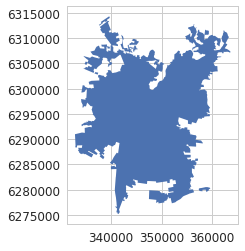

In [17]:
city_shp = gpd.GeoDataFrame.from_file(cl_urban_areas_files[0]).to_crs({'init': 'epsg:5361'}).pipe(
    lambda x: x.loc[x.NOMBRE == city]).reset_index()
city_shp.plot()

In [18]:
city_districts_shp = regional_microdata_shp.assign(
    geometry = regional_microdata_shp.geometry.apply(
        lambda x: city_shp.loc[0].geometry.intersection(x))).pipe(
    lambda x: x.loc[x.area > 0])
city_districts_shp.head()

,REGION,NOM_REGION,PROVINCIA,NOM_PROVIN,COMUNA,NOM_COMUNA,COD_DISTRI,TIPO_DISTR,SHAPE_Leng,SHAPE_Area,...,P03C_4,P03C_5,MATACEP,MATREC,MATIRREC,P05_1,P05_2,P05_3,P05_4,DENSIDAD
15,13,REGIÓN METROPOLITANA DE SANTIAGO,131,SANTIAGO,13124,PUDAHUEL,8,RURAL,0.321355,0.004452,...,15,14,650,154,31,584,163,97,1,63.896453
17,13,REGIÓN METROPOLITANA DE SANTIAGO,131,SANTIAGO,13124,PUDAHUEL,6,MIXTO,0.283998,0.002229,...,67,13,25059,1516,26,26796,6,4,1,4125.868449
18,13,REGIÓN METROPOLITANA DE SANTIAGO,131,SANTIAGO,13124,PUDAHUEL,2,URBANO,0.086290,0.000411,...,156,16,7095,1157,57,8342,10,4,2,7055.221715
19,13,REGIÓN METROPOLITANA DE SANTIAGO,131,SANTIAGO,13124,PUDAHUEL,4,URBANO,0.039365,0.000094,...,35,4,3759,758,12,4550,1,2,1,16992.656847
20,13,REGIÓN METROPOLITANA DE SANTIAGO,131,SANTIAGO,13124,PUDAHUEL,10,URBANO,0.035711,0.000067,...,47,4,2981,497,15,3514,1,0,0,18070.849618


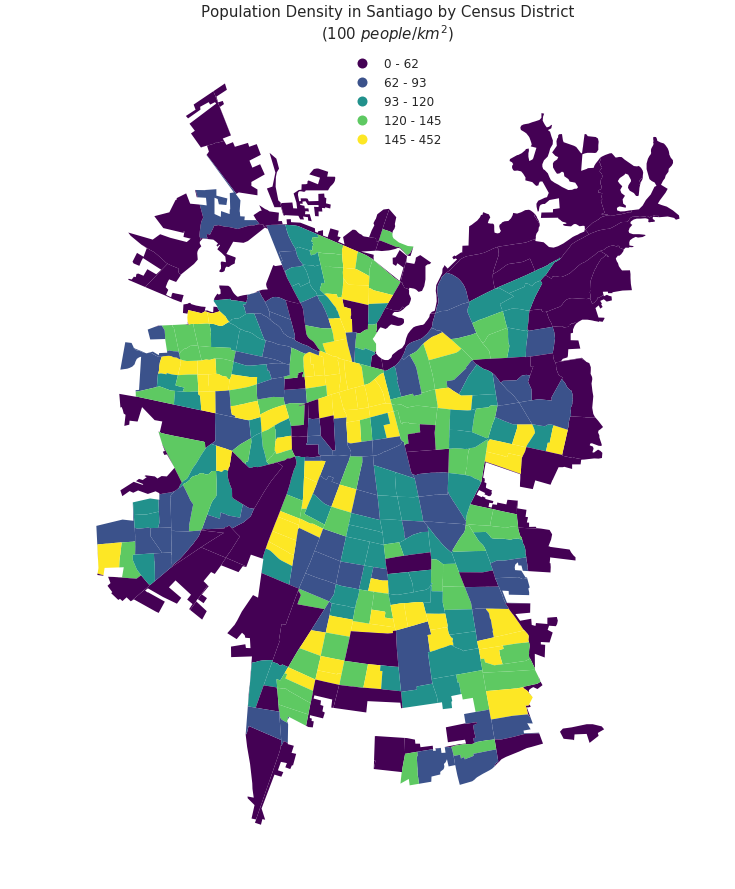

In [45]:
fig, ax = plt.subplots(figsize  = (15, 15))

ax.set_title("Population Density in {} by Census {}\n(100 $people/km^2$)".format(city, analysis_level), fontsize=15)

city_districts_shp.plot(column='DENSIDAD',
                        ax=ax,
                        scheme='Quantiles',
                        k=5,
                        cmap='viridis',
                        lw=0,
                        legend=True,
                        label='hola')

ax.axis('off')

#Legend
leg = ax.get_legend()
leg.set_bbox_to_anchor((0.6, 1, 0, 0))

leg.get_texts()[0].set_text('0 - 62')
leg.get_texts()[1].set_text('62 - 93')
leg.get_texts()[2].set_text('93 - 120')
leg.get_texts()[3].set_text('120 - 145')
leg.get_texts()[4].set_text('145 - 452')

#Correct aspect ratio
ax.axes.set_aspect('equal')

plt.savefig('{}_density_by_{}.png'.format(city, analysis_level), dpi=150, bbox_inches='tight')
plt.show()